In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/privacy/")
from privacy.encode import encodeNonAnonData
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/")

In [2]:
data = "texas"
k_list = [2, 3, 4, 5]
degrees = [1, 2, 3]

In [3]:
_, X_test, y_test = encodeNonAnonData(data, f"/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{data}/test.csv")

Replacing all generalized values...


75555it [00:02, 26310.34it/s]


In [4]:
test_accs_nhs = {}
for i in range(len(k_list)):
    model = tf.keras.models.load_model(f"./weights/model_{data}_{k_list[i]}.h5")
    res = model.evaluate(X_test, y_test, verbose=0)
    test_accs_nhs[f"K = {k_list[i]}"] = res
print(test_accs_nhs)

2023-12-02 14:36:35.044900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-02 14:36:35.045584: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-12-02 14:36:35.563070: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-02 14:36:35.639197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 14:36:44.522706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 14:36:52.990964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 14:37:01.387681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'K = 2': 1.3817890882492065, 'K = 3': 1.8649026155471802, 'K = 4': 3.0866799354553223, 'K = 5': 2.3392457962036133}


In [5]:
test_accs_syb = {}
for i in range(len(degrees)):
    model = tf.keras.models.load_model(f"./syn_weights/model_{data}_{degrees[i]}.h5")
    res = model.evaluate(X_test, y_test, verbose=0)
    test_accs_syb[f"D = {degrees[i]}"] = res
print(test_accs_syb)

2023-12-02 14:37:09.840878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 14:37:18.240038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-02 14:37:26.600994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'D = 1': 0.7416102290153503, 'D = 2': 0.7635374069213867, 'D = 3': 0.7354233860969543}


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

In [7]:
ori = pd.read_csv("./data/texas/train.csv", sep=';')
# syn = pd.read_csv("./synthetic_results/texas_syn_2.csv", sep=';')
control = pd.read_csv("./data/texas/test.csv", sep=';')

In [8]:
ori.drop(["ID"], axis=1, inplace=True)
# syn.drop(["ID"], axis=1, inplace=True)
control.drop(["ID"], axis=1, inplace=True)

In [9]:
inference_risk_nhs = {}
for r in range(100):
    for k in k_list:
        syn = pd.read_csv(f"./nhs_results/texas_anonymized_{k}.csv", sep=';')
        syn.drop(["ID"], axis=1, inplace=True)
        columns = ori.columns
        results = []
        sum_r = 0

        for secret in columns:
            
            aux_cols = [col for col in columns if col != secret]
            
            evaluator = InferenceEvaluator(ori=ori, 
                                        syn=syn, 
                                        control=control,
                                        aux_cols=aux_cols,
                                        secret=secret,
                                        n_attacks=1000)
            evaluator.evaluate(n_jobs=-2)
            results.append((secret, evaluator.results()))
            sum_r += evaluator.results().risk().value
        avg = sum_r / len(columns)
        if r == 0:
            inference_risk_nhs[f"K = {k}"] = avg
        else:
            inference_risk_nhs[f"K = {k}"] += avg
for key in inference_risk_nhs.keys():
    inference_risk_nhs[key] = inference_risk_nhs[key] / 100

/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9841401953760202, baseline = 0.9851363686175346. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.71517342016712, baseline = 0.7430662709295245. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9801555024099624, baseline = 0.9811516756514768. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-scienc

In [10]:
inference_risk_nhs

{'K = 2': 0.028727520699136914,
 'K = 3': 0.024199420547006353,
 'K = 4': 0.026439043983616798,
 'K = 5': 0.023297393888376955}

In [11]:
inference_risk_syn = {}
for r in range(100):
    for d in degrees:
        syn = pd.read_csv(f"./synthetic_results/texas_syn_{d}.csv", sep=';')
        syn.drop(["ID"], axis=1, inplace=True)
        columns = ori.columns
        results = []
        sum_r = 0

        for secret in columns:
            
            aux_cols = [col for col in columns if col != secret]
            
            evaluator = InferenceEvaluator(ori=ori, 
                                        syn=syn, 
                                        control=control,
                                        aux_cols=aux_cols,
                                        secret=secret,
                                        n_attacks=1000)
            evaluator.evaluate(n_jobs=-2)
            results.append((secret, evaluator.results()))
            sum_r += evaluator.results().risk().value
        avg = sum_r / len(columns)
        if r == 0:
            inference_risk_syn[f"D = {d}"] = avg
        else:
            inference_risk_syn[f"D = {d}"] += avg
for key in inference_risk_syn.keys():
    inference_risk_syn[key] = inference_risk_syn[key] / 100

/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9741784629608757, baseline = 0.9801555024099624. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.1603049246435743, baseline = 0.17225900354174764. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.018848324348523127, baseline = 0.028810056763667574. Analysis results cannot be trusted.
  self._sanity_check()
/Users/amirrezasokhankhosh/mambaforge/envs/data

In [12]:
inference_risk_syn

{'D = 1': 0.019949897697629247,
 'D = 2': 0.021229951447525982,
 'D = 3': 0.018973516227703376}

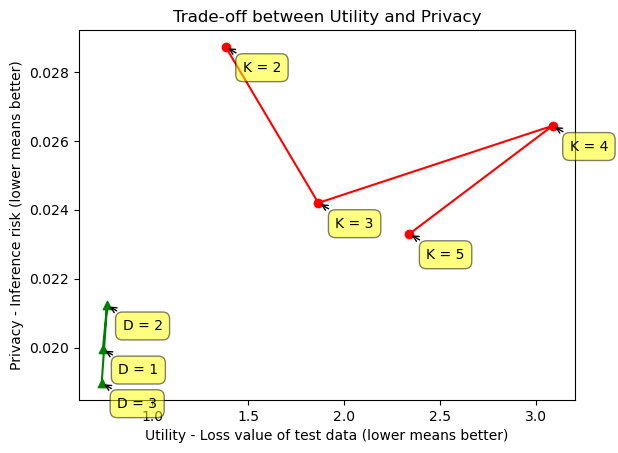

In [18]:
keys = []
for k in k_list:
    key = f"K = {k}"
    keys.append(key)
    plt.scatter(test_accs_nhs[key], inference_risk_nhs[key], label=key, marker='o', c='r')
for d in degrees:
    key = f"D = {d}"
    keys.append(key)
    plt.scatter(test_accs_syb[key], inference_risk_syn[key], label=key, marker = "^", c='g')
plt.plot(test_accs_nhs.values(), inference_risk_nhs.values(), c='r')
plt.plot(test_accs_syb.values(), inference_risk_syn.values(), c='g')
for label, x, y in zip(keys, list(test_accs_nhs.values()) + list(test_accs_syb.values()), list(inference_risk_nhs.values()) + list(inference_risk_syn.values())):
    plt.annotate(
        label,
        xy=(x, y), xytext=(40, -20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.title("Trade-off between Utility and Privacy")
plt.xlabel("Utility - Loss value of test data (lower means better)")
plt.ylabel("Privacy - Inference risk (lower means better)")
plt.show()